In [1]:
# 2023/11/26
# zhangzhong

from module.vision.resnet import ResNet18, SmallResNet18
import torchsummary  # type: ignore
from mytorch.data.cifar10 import CIFAR10Dataset, cifar10_predict
from mytorch.data.svhn import SVHNDataset
import torch
from mytorch import training, utils
import json
from torch import nn, Tensor
from mytorch import utils
from tqdm import tqdm
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from mytorch.data.mnist import MNISTDataset, FashionMNISTDataset

def test_small_resnet_on_svhn() -> None:
    batch_size = 128
    num_workers = 16
    svhn = SVHNDataset(num_workers=num_workers)
    # cifar10 = FashionMNISTDataset()
    train_dataloader = svhn.get_train_dataloader(batch_size=batch_size)
    val_dataloader = svhn.get_val_dataloader(batch_size=batch_size)
    test_dataloader = svhn.get_test_dataloader(batch_size=batch_size)

    tag = 'resnet18_svhn_6'
    net = SmallResNet18()

    lr: float = 0.1
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    warmup_epochs = 5
    num_epochs = 0
    scheduler = SequentialLR(
        optimizer=optimizer,
        schedulers=[
            LinearLR(optimizer=optimizer, start_factor=0.1, total_iters=warmup_epochs),
            CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs-warmup_epochs)
        ],
        milestones=[warmup_epochs]
    )
    device = utils.get_device()
    trainer = training.TrainerV2(
        model=net,
        loss_fn=torch.nn.CrossEntropyLoss(),
        optimizer=optimizer,
        num_epochs=num_epochs,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        test_dataloader=test_dataloader,
        scheduler=scheduler,
        device=device)

    trainer.train(tag=tag)
    pretrained_model = trainer.model

    layers = ['net.last.AdaptiveMaxPool2d', 
              'net.last.LazyLinear1', 
              'net.last.BatchNorm', 
              'net.last.ReLU',
              'net.last.Dropout']
    hook = utils.RegisterIntermediateOutputHook(model=pretrained_model, layers=layers)

    # forward
    intermediate_outputs: dict[str, list[Tensor]] = {}
    for x, y in tqdm(svhn.get_test_dataloader(batch_size=batch_size)):
        x = x.to(device)
        y = pretrained_model(x)
        
        output = hook.get_intermediate_output()
        for layer in layers:
            if layer not in intermediate_outputs:
                intermediate_outputs[layer] = []
            intermediate_outputs[layer].append(output[layer])
   
    for layer in layers:
        outputs = intermediate_outputs[layer]
        outputs = torch.cat(outputs, dim=0)
        utils.draw_tsne(data=outputs, labels=svhn.test_dataset.labels)

    


Using downloaded and verified file: datasets/svhn/train_32x32.mat
Using downloaded and verified file: datasets/svhn/test_32x32.mat


/data/zhangzhong/anaconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 204/204 [00:02<00:00, 76.66it/s] 


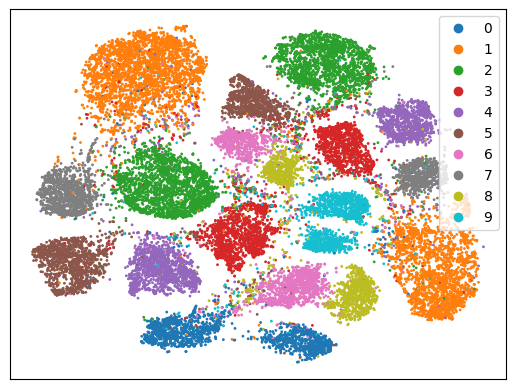

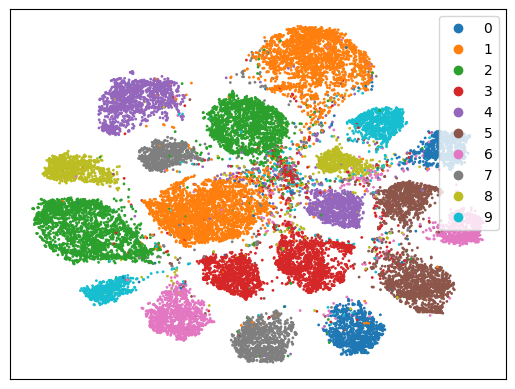

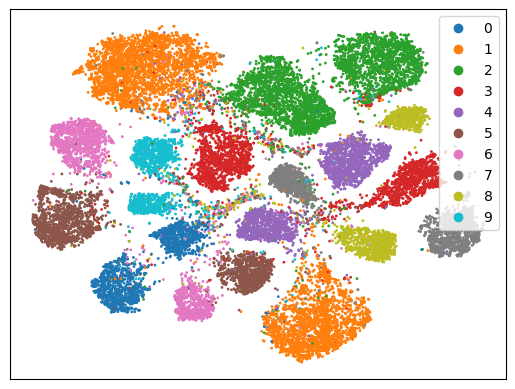

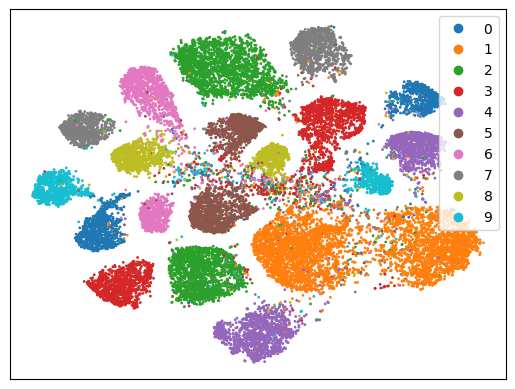

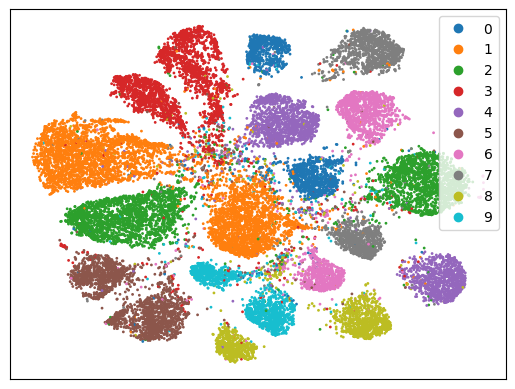

In [2]:
test_small_resnet_on_svhn()